In [27]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_lib import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance

In [28]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2024-01-01"
TO = "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "FTSE 100"

In [29]:
keywords = [
    "FTSE",  # FTSE 100
    "Bank of England",  # Central bank
    "Interest rates",  # Monetary policy
    "Inflation",  # Inflation
    "GDP",  # Gross Domestic Product
    "Economic growth",  # Growth
    "Economic crisis",  # Crisis
    "Recession",  # Recession
    "Economic recovery",  # Recovery
    "Stock market",  # Stock market
    "Investment",  # Investment
    "Equities",  # Equities
    "Fixed income",  # Fixed income
    "Bonds",  # Bonds
    "London Stock Exchange",  # LSE
    "FTSE 100 companies",  # FTSE 100 companies
    "UK economy",  # UK economy
    "Unemployment",  # Unemployment
    "Sterling",  # British Pound
    "Brexit",  # Brexit
    "Trade agreements",  # Trade agreements
    "Consumer confidence",  # Consumer confidence
    "Business confidence",  # Business confidence
    "Market volatility",  # Market volatility
    "Financial markets",  # Financial markets
    "Corporate earnings",  # Corporate earnings
    "Mergers and acquisitions",  # M&A
    "Dividends",  # Dividends
    "Stock prices",  # Stock prices
    "Market trends",  # Market trends
    "Economic indicators",  # Economic indicators
    "Fiscal policy",  # Fiscal policy
    "Government spending",  # Government spending
    "Public debt",  # Public debt
    "Taxation",  # Taxation
    "Consumer spending",  # Consumer spending
    "Business investment",  # Business investment
    "Financial stability",  # Financial stability
    "Banking sector",  # Banking sector
]

In [30]:
# Fetch news data function
def fetch_ftse_news_data():
    from pygooglenews import GoogleNews
    
    # Helper function to convert news to DataFrame
    def convert_to_dataframe(news):
        data = []
        for article in news['entries']:
            try:
                # Try the original format first
                date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
            except ValueError:
                # If that fails, use pd.to_datetime which is more flexible
                date = pd.to_datetime(article['published'])
                # Convert timezone-aware datetime to timezone-naive
                if date.tzinfo is not None:
                    date = date.replace(tzinfo=None)
            title = article['title']
            data.append({'date': date, 'title': title})
        return pd.DataFrame(data)
    
    # Create Google News instance
    gn = GoogleNews(lang="en", country="GB")
    
    # Search for news with the keywords
    news = gn.search(
        query=" OR ".join(keywords),
        from_=FROM,
        to_=TO,
    )
    
    # Convert to DataFrame
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])
    
    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    df.to_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", index=False)
    
    return df

In [31]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ftse_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 100 news articles


In [32]:
# Fetch FTSE 100 market data using yfinance
ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ftse100_data = ftse100_data.reset_index()  # Convert index to column
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna().reset_index(drop=True)

print(f"Loaded {len(ftse100_data)} days of FTSE 100 market data")
ftse100_data.head()

Loaded 332 days of FTSE 100 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2024-01-31 00:00:00+00:00,7666.299805,7689.700195,7630.600098,7630.600098,952428700,0.0,0.0,-0.004657,0.098211
1,2024-02-01 00:00:00+00:00,7630.600098,7673.700195,7607.899902,7622.200195,936217800,0.0,0.0,-0.001101,0.096856
2,2024-02-02 00:00:00+00:00,7622.200195,7670.899902,7609.299805,7615.500000,859451400,0.0,0.0,-0.000879,0.094640
3,2024-02-05 00:00:00+00:00,7615.500000,7667.799805,7598.700195,7612.899902,1350635500,0.0,0.0,-0.000341,0.093687
4,2024-02-06 00:00:00+00:00,7612.899902,7693.600098,7612.899902,7681.000000,1499137700,0.0,0.0,0.008945,0.099177


Calculating enhanced sentiment scores...
Final feature columns for model: ['Volatility_Smooth', 'RSI', 'MA_Ratio', 'Volume_Ratio', 'sentiment', 'sentiment_3d', 'sentiment_vol', 'news_sentiment_interaction']


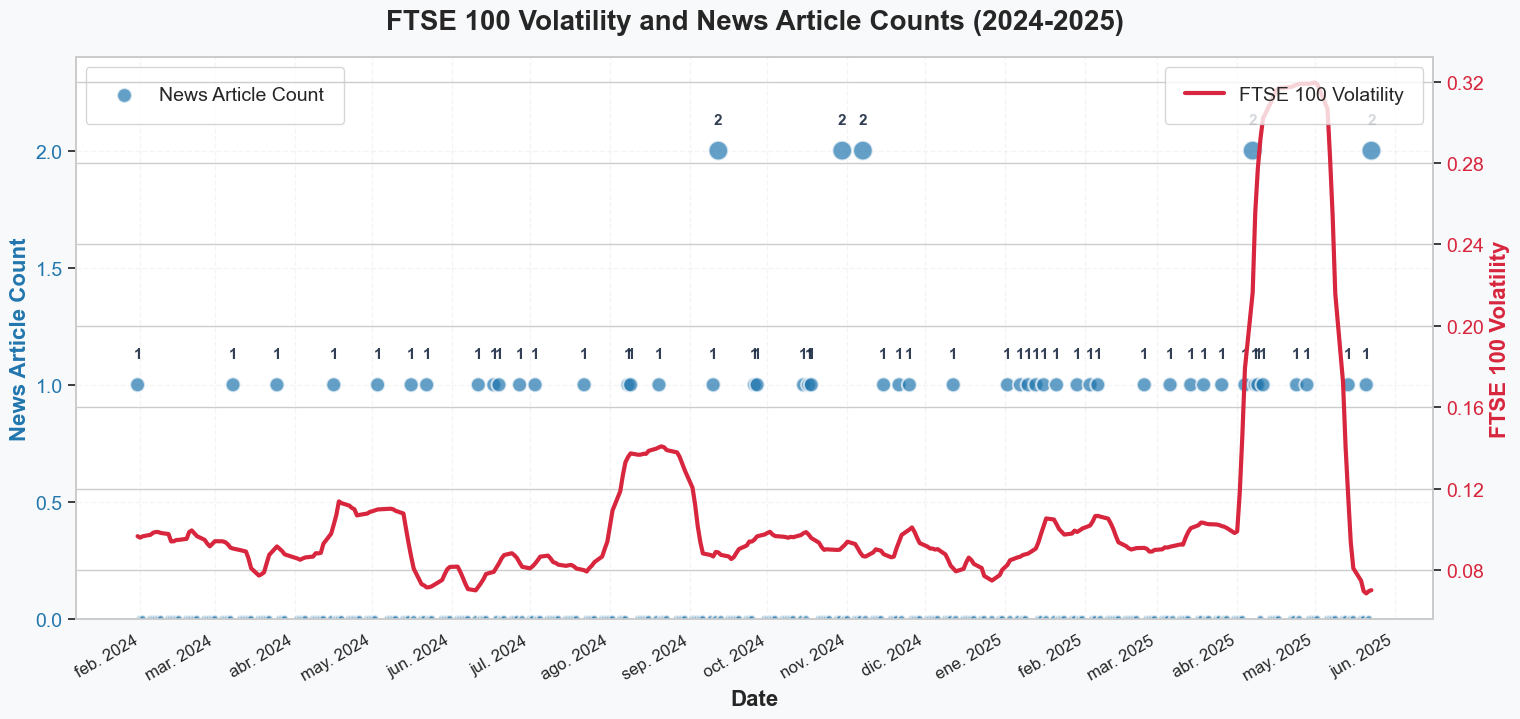

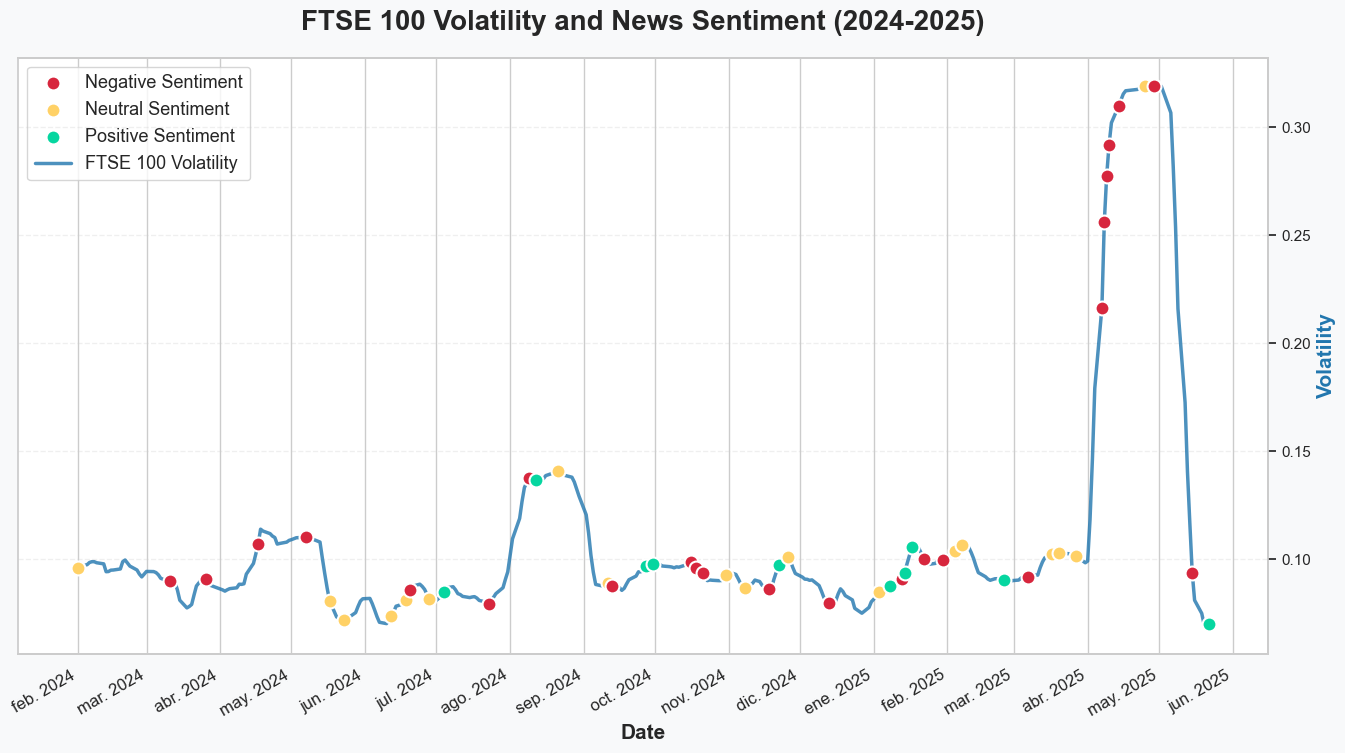

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Epoch 1/50, Train Loss: 0.16964, Val Loss: 0.04649
Epoch 10/50, Train Loss: 0.04107, Val Loss: 0.01916
Early stopping at epoch 19
Evaluating enhanced LSTM model...
Model Performance Metrics:
MSE: 0.003512
RMSE: 0.059261
MAE: 0.027714
R² Score: 0.344721


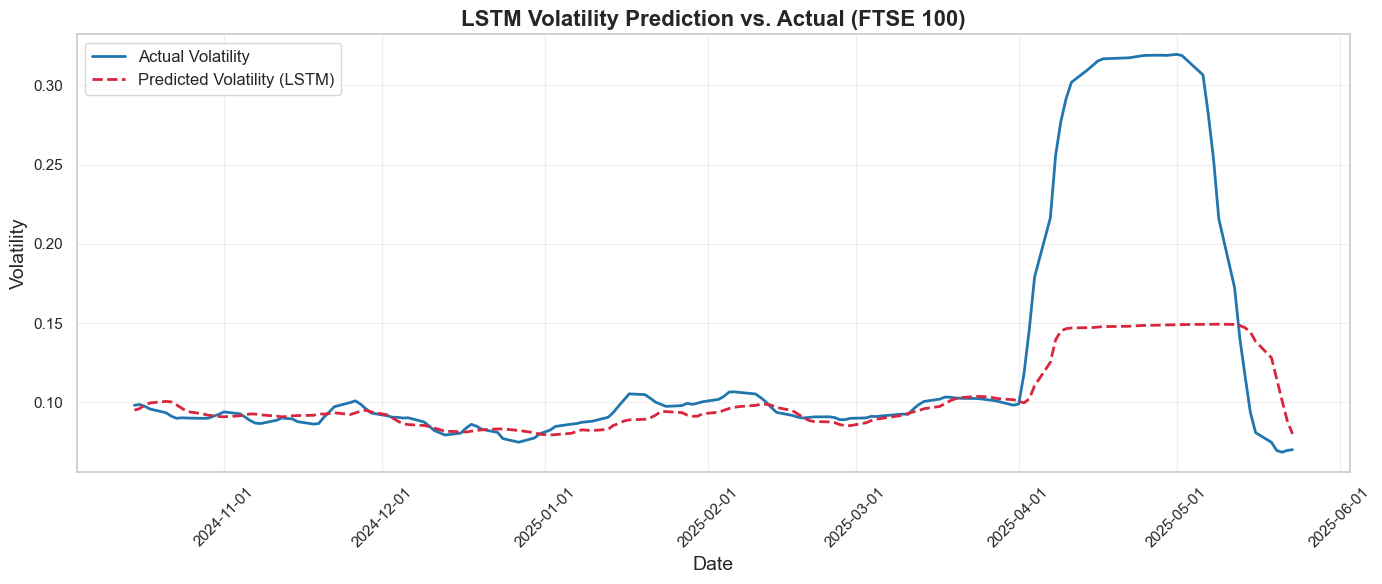

In [33]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    verbose=True
)

In [34]:
# Display model metrics
metrics = results['metrics']
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

MSE: 0.003512
RMSE: 0.059261
MAE: 0.027714
R2: 0.344721


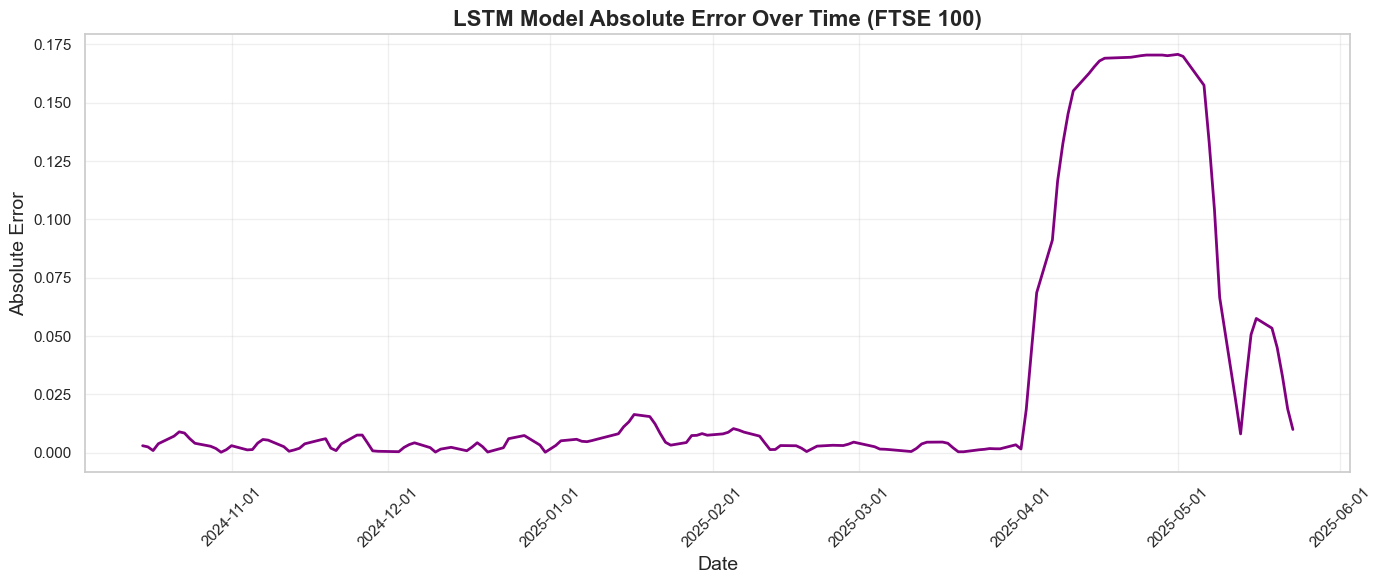

In [35]:
error = np.abs(results['y_actual'] - results['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Skipping sentiment calculation (use_sentiment=False)...
Final feature columns for model: ['Volatility_Smooth', 'RSI', 'MA_Ratio', 'Volume_Ratio']


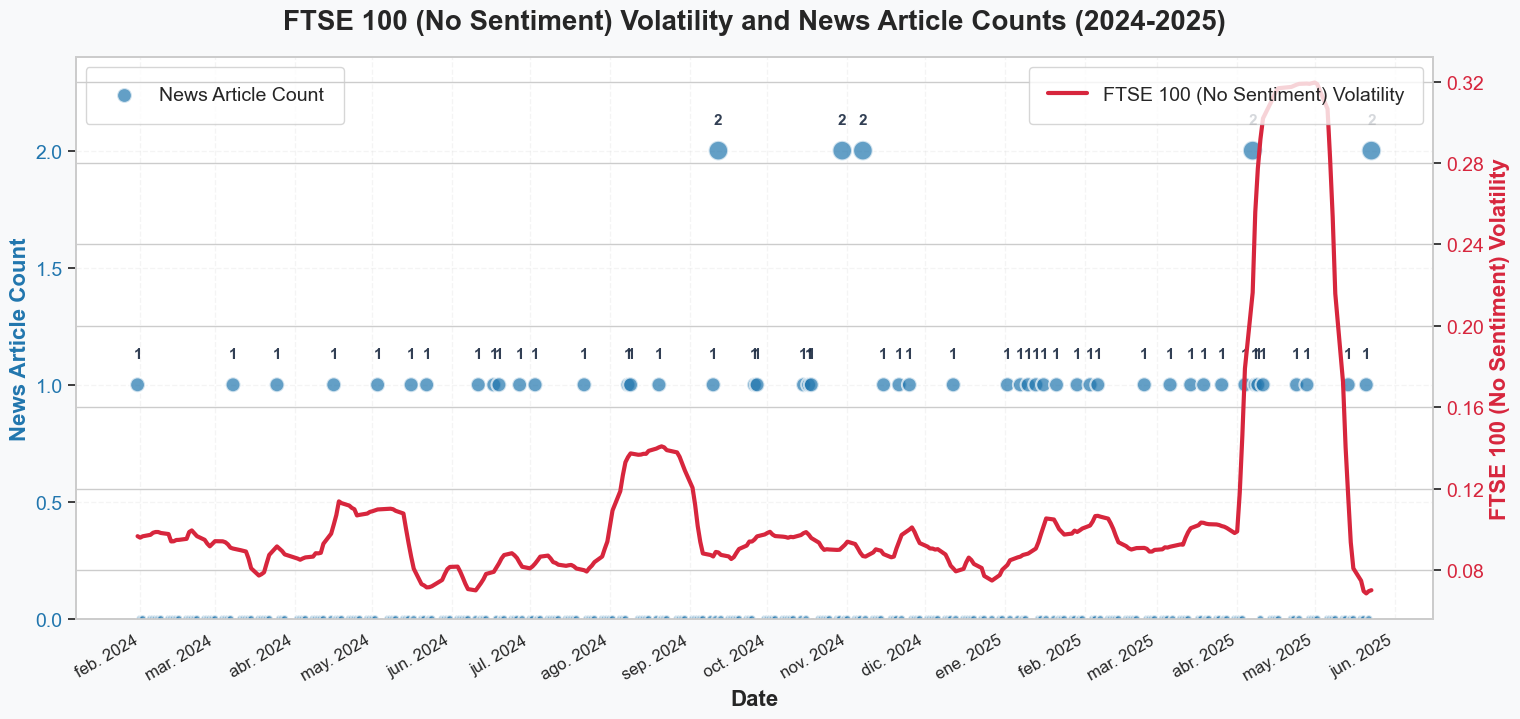

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Epoch 1/50, Train Loss: 0.16262, Val Loss: 0.05459
Epoch 10/50, Train Loss: 0.03702, Val Loss: 0.01761
Early stopping at epoch 20
Evaluating enhanced LSTM model...
Model Performance Metrics:
MSE: 0.004368
RMSE: 0.066093
MAE: 0.029862
R² Score: 0.184911


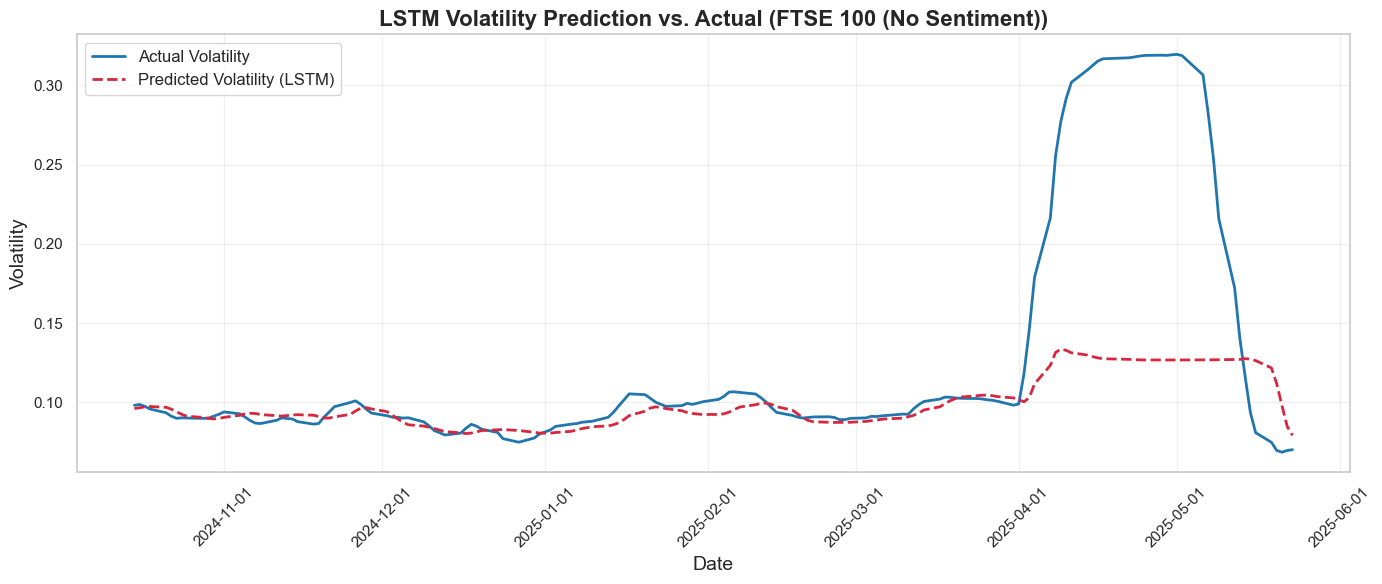

In [36]:
# Example: Run volatility analysis WITHOUT sentiment inference
# This uses only previous volatility data for predictions
results_no_sentiment = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME + " (No Sentiment)",
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    use_sentiment=False,  # NEW PARAMETER: Skip sentiment inference
    verbose=True
)

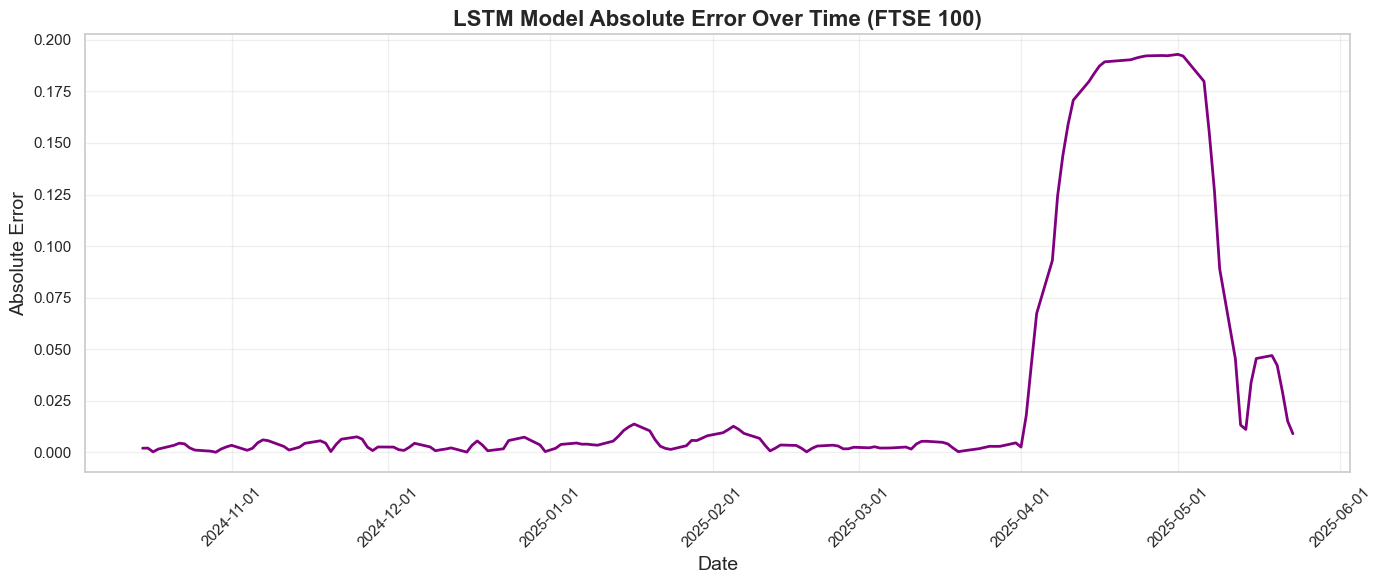

In [37]:
error = np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results_no_sentiment['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../news/ftse100_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

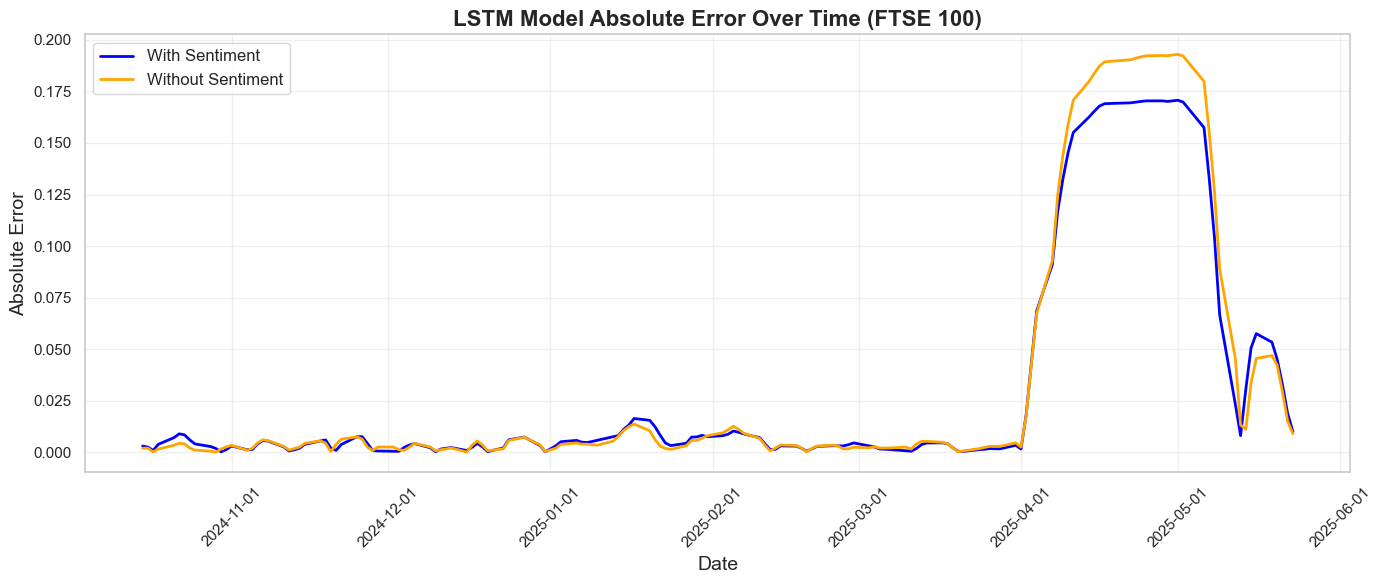

In [38]:
# Plot the MAE over time for both models
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], np.abs(results['y_actual'] - results['y_pred']), label='With Sentiment', color='blue', linewidth=2)
plt.plot(results_no_sentiment['test_dates'], np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred']), label='Without Sentiment', color='orange', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Compare metrics between sentiment-based and volatility-only models
print("\n=== MODEL COMPARISON ===")
print("With Sentiment:")
for metric_name, value in results['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")

print("\nWithout Sentiment (Volatility-only):")
for metric_name, value in results_no_sentiment['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")


=== MODEL COMPARISON ===
With Sentiment:
  MSE: 0.003512
  RMSE: 0.059261
  MAE: 0.027714
  R2: 0.344721

Without Sentiment (Volatility-only):
  MSE: 0.004368
  RMSE: 0.066093
  MAE: 0.029862
  R2: 0.184911
